Question 2) Find all the mentions of world countries in the whole corpus, 
using the pycountry utility (HINT: remember that there will be different surface forms 
for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) 
Perform sentiment analysis on every email message using the demo methods 
in the nltk.sentiment.util module. Aggregate the polarity information of all 
the emails by country, and plot a histogram (ordered and colored by polarity level) 
that summarizes the perception of the different countries. Repeat the aggregation and plotting steps using different demo methods from the sentiment analysis module.
Can you find substantial differences?

In [51]:
import pandas as pd
import pycountry
from nltk.sentiment import *
import numpy as np
import matplotlib.pyplot as plt
import codecs
import math
import re
import string



Pre Process the Data, Dropping Irrelevant Columns

In [204]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")


In [205]:
# Drop columns that won't be used
emails = emails.drop(['DocNumber', 'MetadataPdfLink','DocNumber', 'ExtractedDocNumber', 'MetadataCaseNumber'], axis=1)
emails.head()

,Id,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [206]:
emails_cut = emails[['ExtractedBodyText']].copy()
emails_cut.head()

,ExtractedBodyText
0,NaN
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Thx
3,NaN
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


In [207]:
emails_cut = emails_cut.dropna()
emails_cut.head()


,ExtractedBodyText
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Thx
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


Now we must tokenize the data...

In [208]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
tokenizer = RegexpTokenizer(r'\w+')

In [209]:
emails_tokenized = emails_cut.copy()
for index, row in emails_tokenized.iterrows():
    row['ExtractedBodyText'] = tokenizer.tokenize(row['ExtractedBodyText'])
emails_tokenized.columns = ['TokenizedText']
emails_tokenized.reset_index(drop=True, inplace=True)
emails_tokenized.head()

,TokenizedText
0,"[B6, Thursday, March, 3, 2011, 9, 45, PM, H, L..."
1,[Thx]
2,"[H, hrod17, clintonemail, com, Friday, March, ..."
3,"[Pis, print, H, hrod17, clintonernailcom, Wedn..."
4,"[H, hrod17, clintonemail, corn, Friday, March,..."


Figure out what words to remove...

In [210]:
words_delete = ['IT', 'RE','LA','AND', 'AM', 'AT', 'IN', 'I', 'ME', 'DO', 
                'A', 'AN','BUT', 'IF', 'OR','AS','OF','BY', 'TO', 'UP','ON','ANY', 'NO', 'NOR', 'NOT','SO',
                'S', 'T','DON','D', 'LL', 'M', 'O','VE', 'Y','PM', 'TV','CD','PA','ET', 'BY', 'IE','MS', 'MP', 'CC', 
                'GA','VA', 'BI','CV', 'AL','VAT', 'VA','AI', 'MD', 'SM', 'FM', 'EST', 'BB', 'BRB', 'AQ', 'MA', 'MAR', 'JAM', 'BM', 
                'Lybia', 'LY', 'LBY', 'MC', 'MCO', 'MO', 'MAC', 'NC', 'PG', 'PNG', 'SUR', 'VI', 'lybia', 'ARM'] 
emails_final = emails_tokenized.copy()
emails_final['TokenizedText'] = emails_final['TokenizedText'].apply(lambda x: [item for item in x if item not in words_delete])
emails_final.head()

,TokenizedText
0,"[B6, Thursday, March, 3, 2011, 9, 45, H, Lates..."
1,[Thx]
2,"[H, hrod17, clintonemail, com, Friday, March, ..."
3,"[Pis, print, H, hrod17, clintonernailcom, Wedn..."
4,"[H, hrod17, clintonemail, corn, Friday, March,..."


Create list of countries

In [211]:
countries_cited = []
for emails in emails_final['TokenizedText']:
    for word in emails:
        try:
            country_name = pycountry.countries.get(alpha_2=word)
            countries_cited.append(country_name.name)
        except KeyError:
            try:
                country_name = pycountry.countries.get(alpha_3=word)
                countries_cited.append(country_name.name)
            except KeyError:
                try:
                    country = pycountry.countries.get(name=word)
                    countries_cited.append(country_name.name)
                except KeyError: pass


Organize List and Count Occurrence of Each Country

In [212]:
#List with Unique Entries of Countries Cited
final_countries = list(set(countries_cited))
size = len(final_countries)
final_countries

['Qatar',
 'New Zealand',
 'Greece',
 'Tunisia',
 'Indonesia',
 'Brazil',
 'China',
 'British Indian Ocean Territory',
 'Palestine, State of',
 'Japan',
 'Myanmar',
 'Hong Kong',
 'Georgia',
 'Kenya',
 'Argentina',
 'Switzerland',
 'Congo',
 'Sudan',
 'Comoros',
 'Puerto Rico',
 'Malaysia',
 'Colombia',
 'Australia',
 'Belgium',
 'Hungary',
 'Luxembourg',
 'Peru',
 'Turkmenistan',
 'Jamaica',
 'Svalbard and Jan Mayen',
 'Iceland',
 'Brunei Darussalam',
 'Somalia',
 'Finland',
 'Denmark',
 'Costa Rica',
 'Mauritius',
 'Guinea-Bissau',
 'Saudi Arabia',
 'Mongolia',
 'Sierra Leone',
 'Poland',
 'Nauru',
 'Thailand',
 'Lithuania',
 'Slovenia',
 'Iraq',
 'Liechtenstein',
 'Portugal',
 'Singapore',
 'Cuba',
 'Bahamas',
 'Bosnia and Herzegovina',
 'Israel',
 'Azerbaijan',
 'Namibia',
 'Marshall Islands',
 'Serbia',
 'Canada',
 'Philippines',
 'Tuvalu',
 'Gambia',
 'Kiribati',
 'Samoa',
 'Germany',
 'United States',
 'Cayman Islands',
 'Trinidad and Tobago',
 'Seychelles',
 'Czechia',
 'Afghan

In [213]:
#Create New DataFrame for the Counts
Country_Sent = pd.DataFrame(index=range(0,size),columns=['Country', 'Count'])
Country_Sent['Country']=final_countries
Country_Sent.head()

,Country,Count
0,Qatar,NaN
1,New Zealand,NaN
2,Greece,NaN
3,Tunisia,NaN
4,Indonesia,NaN


In [214]:
count_list = []
for country in Country_Sent['Country']:
    count = countries_cited.count(country)
    count_list.append(count)
    
Country_Sent['Count']=count_list
Country_Sent.head()



,Country,Count
0,Qatar,1
1,New Zealand,31
2,Greece,1
3,Tunisia,10
4,Indonesia,9


In [215]:
#Take Out Countries with Less than 20 Citations
Country_Sent= Country_Sent[Country_Sent['Count'] > 14]
Country_Sent = Country_Sent.reset_index(drop=True)
Country_Sent.head()


,Country,Count
0,New Zealand,31
1,Georgia,47
2,Puerto Rico,72
3,Australia,42
4,Hungary,17


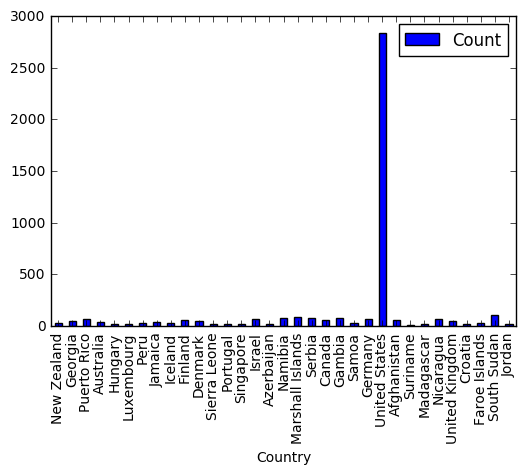

In [216]:
#plot to see frequencies
Country_Sent.plot.bar(x='Country', y='Count')
plt.show()

#We have repeatedly plotted this, identifying weird occurances (small countries with high counts), 
#and then elimitating them from the data set and repating the process

In [217]:
#create a list with all possible names of the countries above
countries_used_name = []
countries_used_alpha_2 =[]
countries_used_alpha_3 =[]

for country in Country_Sent['Country']:
    country_names = pycountry.countries.get(name=country)
    countries_used_name.append(country_names.name)
    countries_used_alpha_2.append(country_names.alpha_2)
    countries_used_alpha_3.append(country_names.alpha_3)

Country_Sent['Alpha_2']=countries_used_alpha_2
Country_Sent['Alpha_3']=countries_used_alpha_3

Country_Sent.head()

,Country,Count,Alpha_2,Alpha_3
0,New Zealand,31,NZ,NZL
1,Georgia,47,GE,GEO
2,Puerto Rico,72,PR,PRI
3,Australia,42,AU,AUS
4,Hungary,17,HU,HUN


In [218]:
len(Country_Sent)

33

Now we check sentiment on emails around these names

In [170]:
sentiments = []
vader_analyzer = SentimentIntensityAnalyzer()

size = len(Country_Sent['Alpha_2'])
for i in range(1,size):
    country_score =[]
    for email in emails_no_stop['TokenizedText']:
        if Country_Sent['Alpha_2'][i] in email or Country_Sent['Alpha_3'][i] in email or Country_Sent['Country'][i] in email:
            str_email = ' '.join(email)
            sentiment = vader_analyzer.polarity_scores(str_email)
            score = sentiment['compound']
            country_score.append(score)
        else: pass
    if len(country_score)!=0:
        sentiment_score = sum(country_score) / float(len(country_score))
        sentiments.append(sentiment_score)
    else:
        sentiments.append(999)

                   
              
        

In [291]:
sentiments

[0.9233285714285714,
 999,
 0.45655454545454544,
 -0.8763,
 0.9737,
 0.10115,
 0.41584000000000004,
 -0.11475000000000002,
 0.06646666666666667,
 999,
 0.5107125,
 -0.1806333333333333,
 0.7321749999999999,
 0.3337464285714288,
 0.49528333333333335,
 999,
 999,
 0.9945,
 0.15544,
 999,
 0.6249,
 -0.0959,
 999,
 0.38092038834951447,
 0.989,
 0.8434999999999999,
 0.0,
 999,
 999,
 999,
 999,
 0.4625473684210526]

In [220]:
#error in iteration, must drop NZ because it was not taken into account in the sentiments analysis
Country_Sent = Country_Sent.drop(Country_Sent.index[[0]])

len(Country_Sent)

32

In [222]:
#add sentiment list to data frame
Country_Sent['Sentiment'] = sentiments
Country_Sent.head()

,Country,Count,Alpha_2,Alpha_3,Sentiment
1,Georgia,47,GE,GEO,0.923329
2,Puerto Rico,72,PR,PRI,999.000000
3,Australia,42,AU,AUS,0.456555
4,Hungary,17,HU,HUN,-0.876300
5,Luxembourg,18,LU,LUX,0.973700


In [224]:
#delete any row with sentiment value of 999
Country_Sent = Country_Sent[Country_Sent['Sentiment'] != 999]
Country_Sent.head()

,Country,Count,Alpha_2,Alpha_3,Sentiment
1,Georgia,47,GE,GEO,0.923329
3,Australia,42,AU,AUS,0.456555
4,Hungary,17,HU,HUN,-0.876300
5,Luxembourg,18,LU,LUX,0.973700
6,Peru,26,PE,PER,0.101150


In [226]:
#reorder dataframe in ascending order of sentiment
Country_Sent.sort_values(['Sentiment'], ascending=True, inplace=True)
Country_Sent.head()

,Country,Count,Alpha_2,Alpha_3,Sentiment
4,Hungary,17,HU,HUN,-0.876300
12,Portugal,23,PT,PRT,-0.180633
8,Iceland,32,IS,ISL,-0.114750
22,Germany,72,DE,DEU,-0.095900
27,Nicaragua,66,NI,NIC,0.000000


In [254]:
#reorder index
Country_Sent = Country_Sent.reset_index(drop=True)

Country_Sent.head()

,Country,Count,Alpha_2,Alpha_3,Sentiment,color_grad
0,Hungary,17,HU,HUN,-0.876300,"(1.0, 0, 0.0, 1)"
1,Portugal,23,PT,PRT,-0.180633,"(1.79386815778, 0, -0.793868157785, 1)"
2,Iceland,32,IS,ISL,-0.114750,"(1.86905169463, 0, -0.869051694625, 1)"
3,Germany,72,DE,DEU,-0.095900,"(1.89056259272, 0, -0.890562592719, 1)"
4,Nicaragua,66,NI,NIC,0.000000,"(0, 1.0, 0.0, 1)"


Now we make a color gradient for the histogram

In [288]:
#We must normalize the sentiment scores and create a gradient based on that (green, blue & red gradient)
#first we sort the ones that are below zero, than the ones above zero
color_grad = []
size = len(Country_Sent['Sentiment'])

for i in range(0,size):
    if Country_Sent['Sentiment'][i] < 0:
        high = 0
        low = np.min(sentiments)
        rg = low-high
        new_entry = (low-Country_Sent['Sentiment'][i])/rg
        red = 1 - new_entry
        color_grad.append((red,0,0))
    else:
        high = np.max(sentiments)
        low = 0
        rg2 = high-low
        new_entry = (Country_Sent['Sentiment'][i]-low)/rg2
        green = 1 - new_entry
        color_grad.append((0,green,0))    
                          
        
        

Country_Sent['color_grad'] = color_grad        
Country_Sent.head()


,Country,Count,Alpha_2,Alpha_3,Sentiment,color_grad
0,Hungary,17,HU,HUN,-0.876300,"(1.0, 0, 0)"
1,Portugal,23,PT,PRT,-0.180633,"(0.206131842215, 0, 0)"
2,Iceland,32,IS,ISL,-0.114750,"(0.130948305375, 0, 0)"
3,Germany,72,DE,DEU,-0.095900,"(0.109437407281, 0, 0)"
4,Nicaragua,66,NI,NIC,0.000000,"(0, 1.0, 0)"


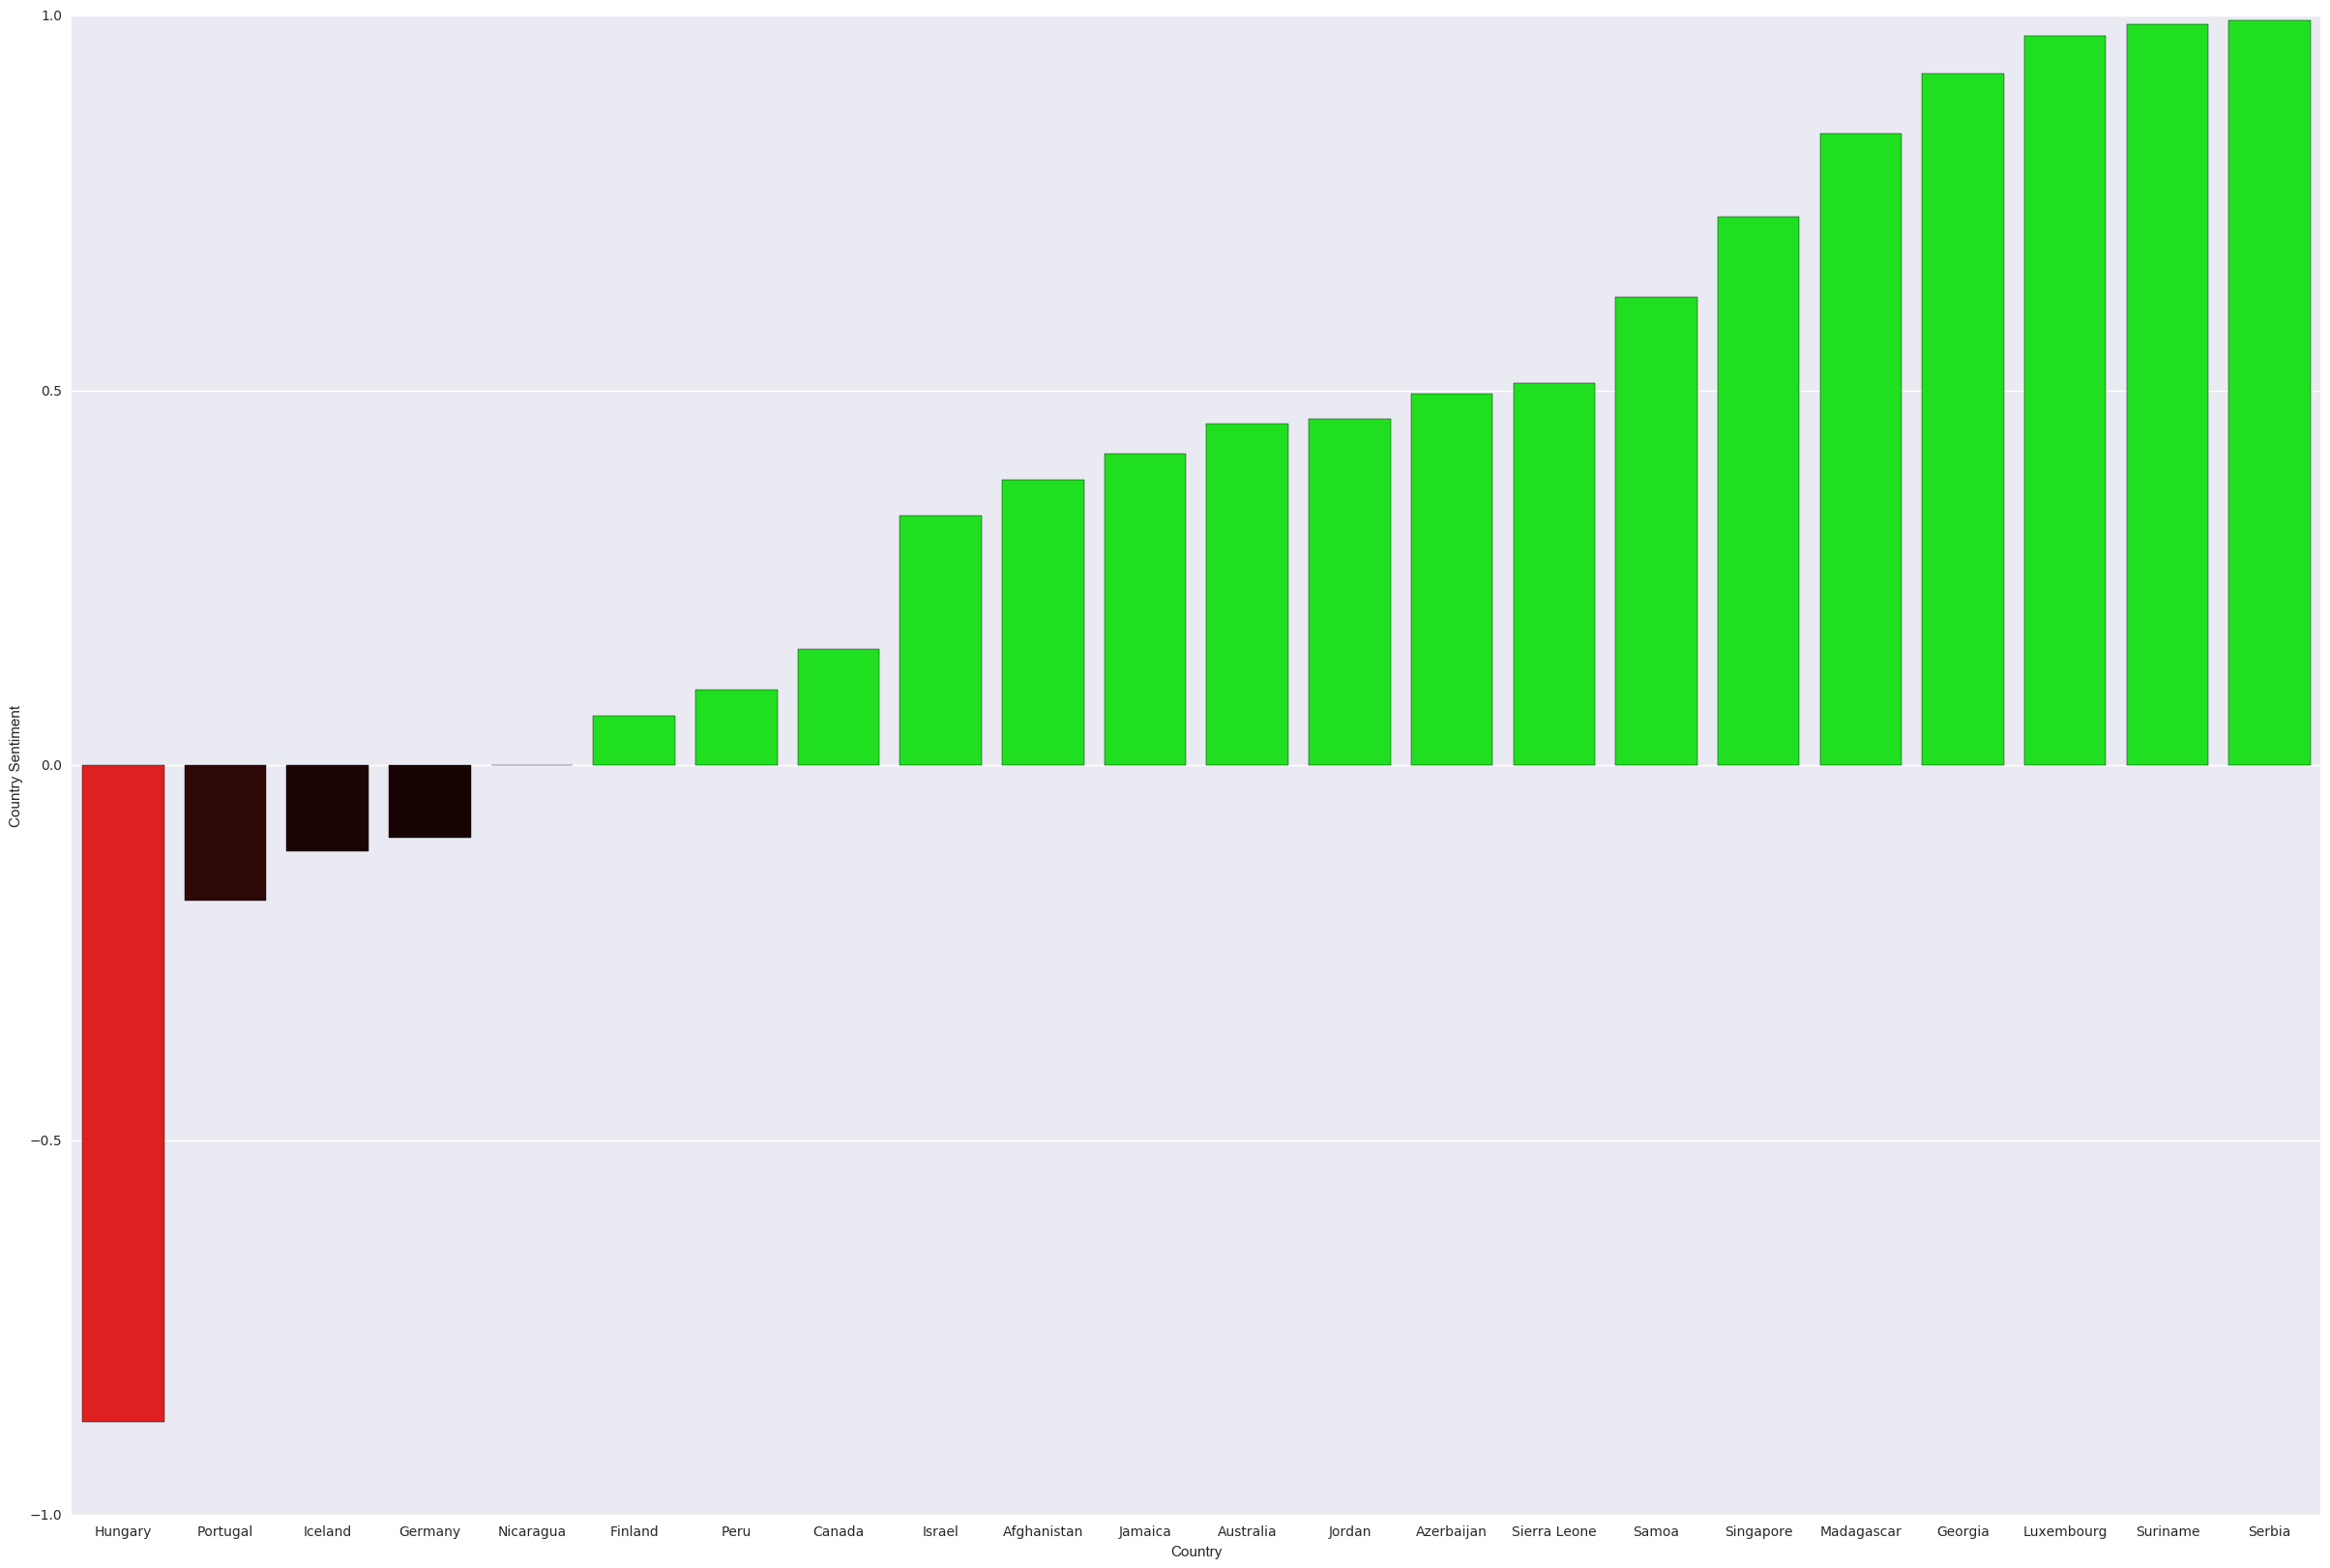

In [289]:
#Now we create the bar plot based on this palette
import seaborn as sns
plt.figure(figsize=(30,20))
plot = sns.barplot(x='Country', y='Sentiment', data=Country_Sent, orient='vertical', palette=color_grad)
plt.ylabel('Country Sentiment');
plt.show()

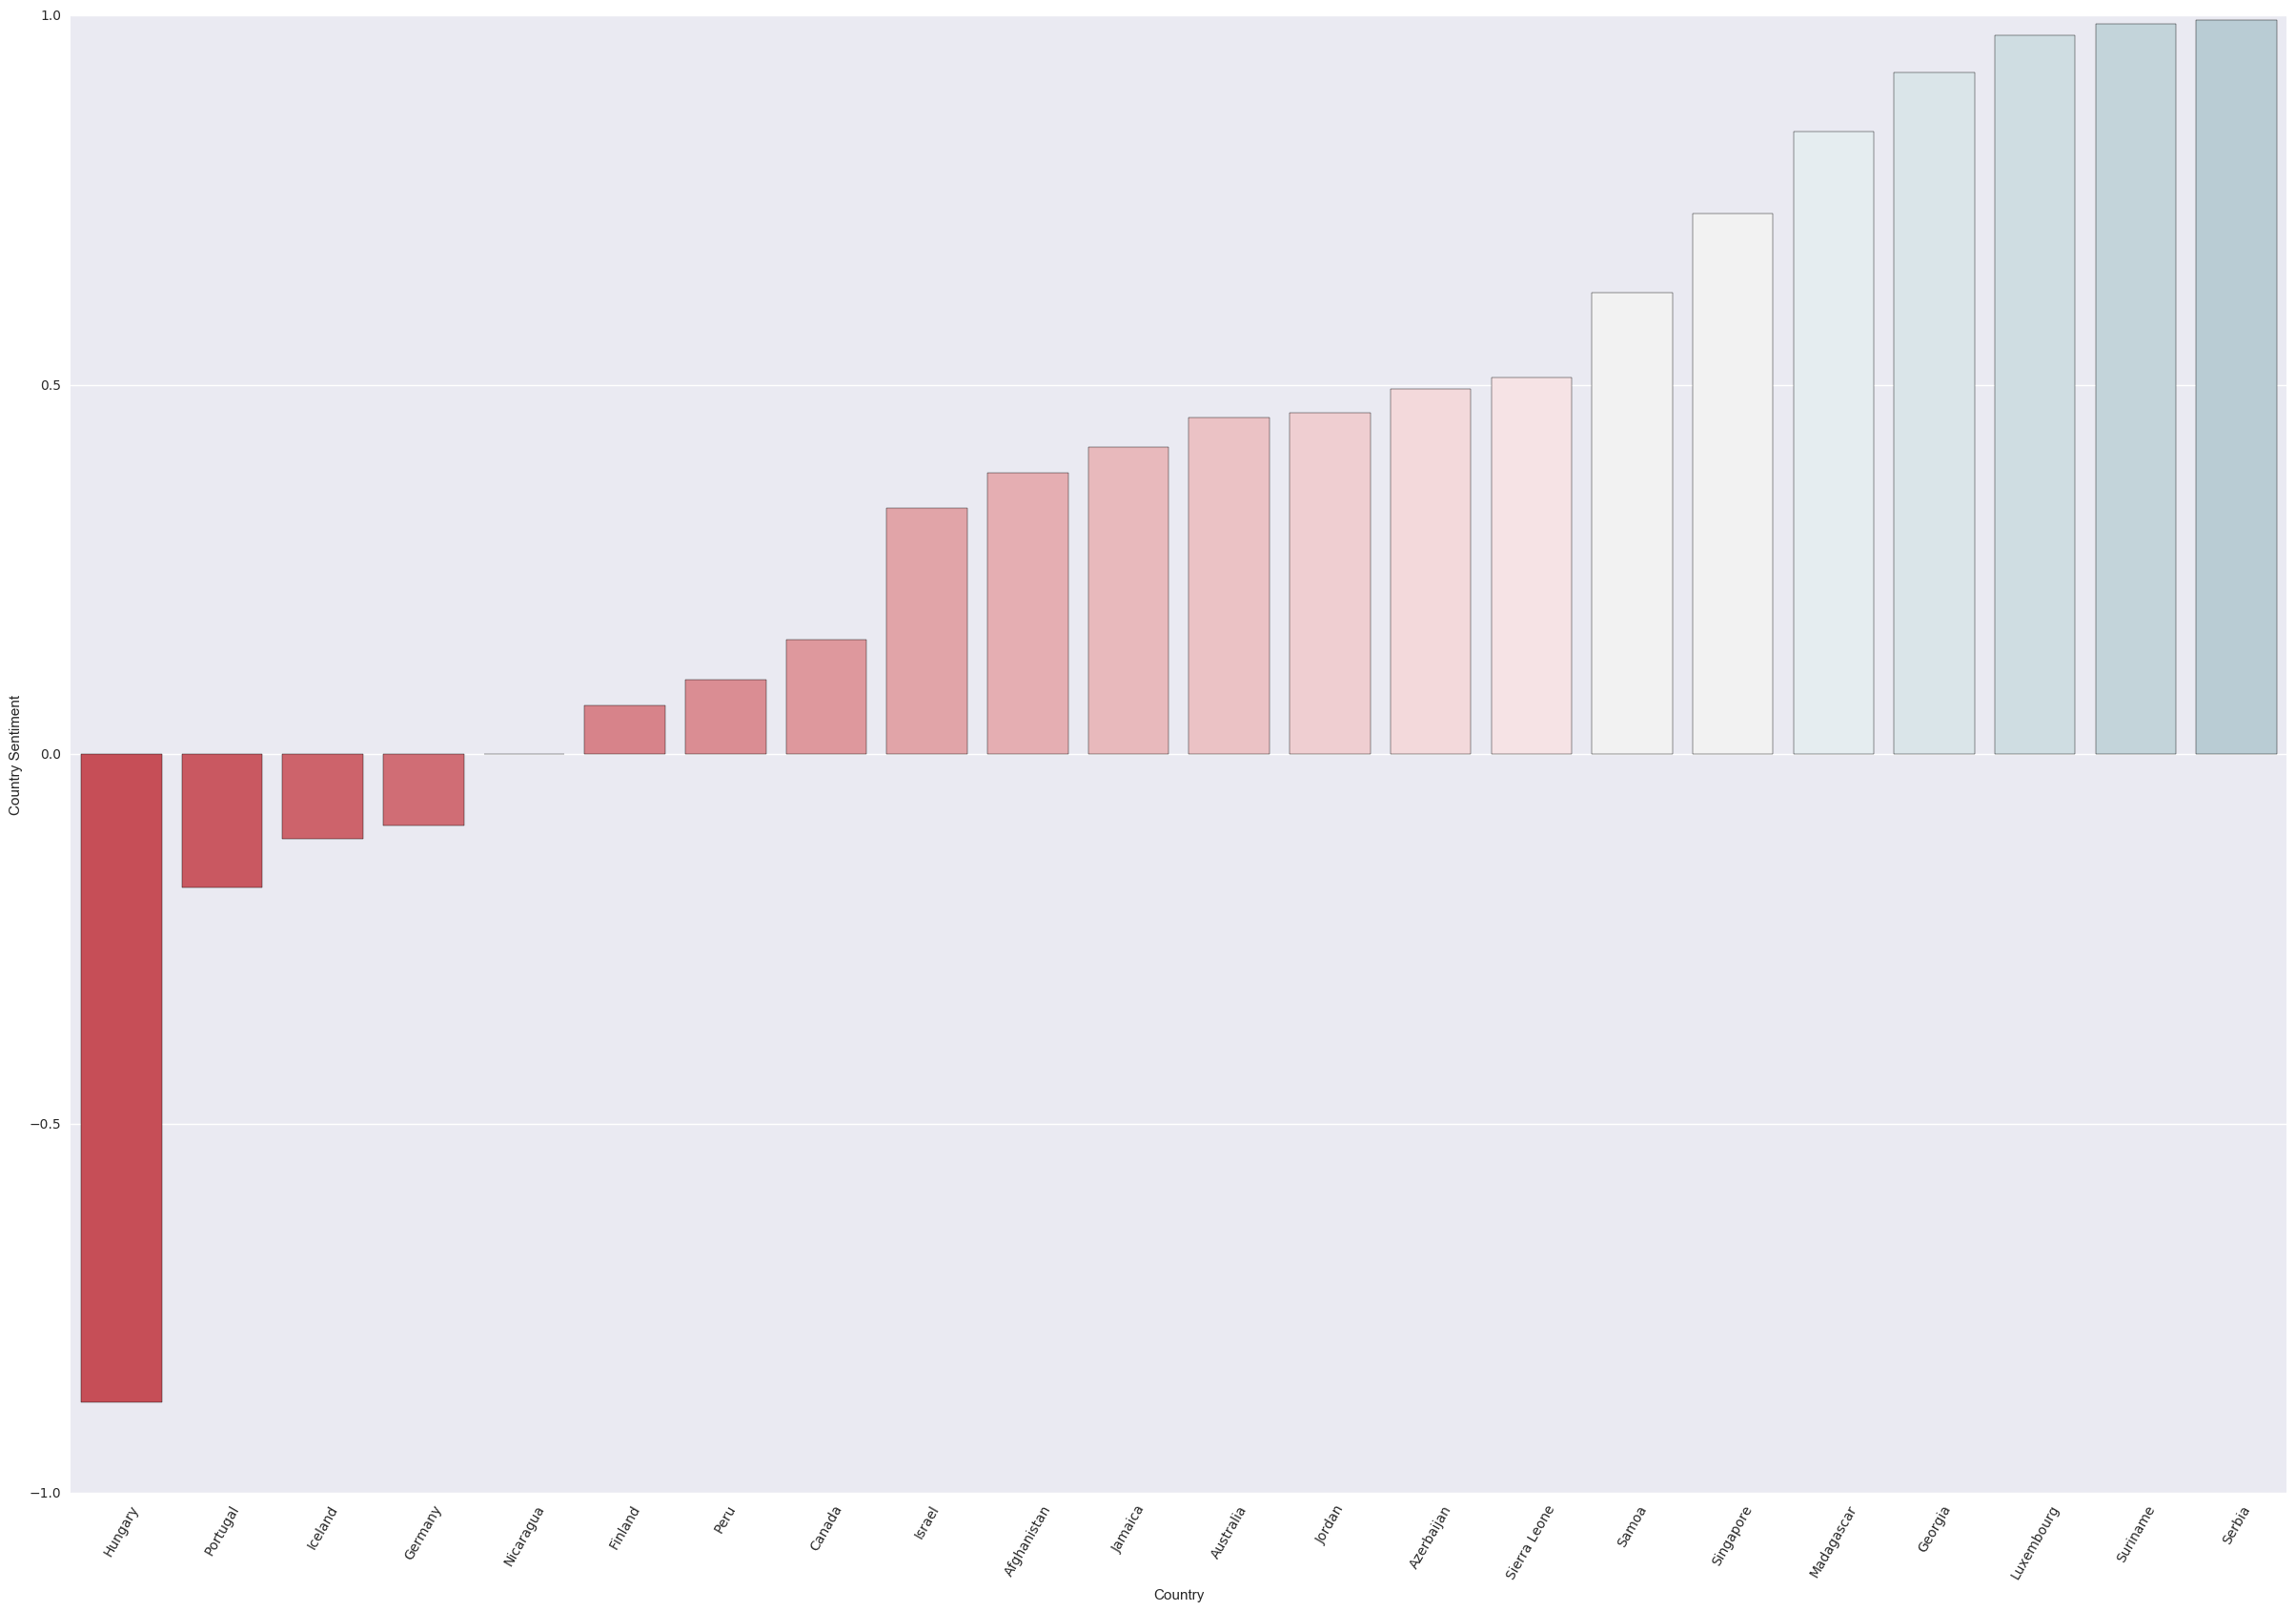

In [252]:
#Now we create a bar plot with an automatic gradient based on sentiment
size = len(Country_Sent['Sentiment'])
plt.figure(figsize=(30,20))
grad = sns.diverging_palette(10, 225, n=32)
plot = sns.barplot(x='Country', y='Sentiment', data=Country_Sent, orient='vertical', palette = grad )
plt.xticks(rotation=60);
plt.ylabel('Country Sentiment');
plt.show()

Comment on Sentiment Data:
    Some Countries Were lost in this analysis, it is not clear why yet.
Comments on Data Viz:
    Creating my own pallette somehow erased the nuances between countries even when the difference in 
    scores was significant. The automaticallly generated palette performed much better at conveying the info.